In [1]:
%matplotlib inline

In [2]:
# Set the correct working directory
import os
if 'paper_exp' in os.path.abspath(os.curdir).split('/'):
    while os.path.abspath(os.curdir).split('/')[-1] != 'paper_exp':
        os.chdir(os.pardir)
    os.chdir(os.pardir)
print("current working directory: {}".format(os.path.abspath(os.getcwd())))

current working directory: /home/jenny/Documents/research/projects/linear-ae/linear-autoencoder


In [3]:
import wandb
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import numpy as np

In [4]:
from models.model_config import ModelTypes

In [5]:
api = wandb.Api()

In [6]:
model_names = ["deterministic_nd", "nd", ModelTypes.NON_UNIFORM_SUM, ModelTypes.ROTATION, ModelTypes.VAE, ModelTypes.UNIFORM_SUM]

model_to_metric = {model_type: model_type for model_type in ModelTypes.VALID_MODEL_TYPES}
model_to_metric[ModelTypes.NESTED_DROPOUT] = 'nd_expectation'

In [7]:
hdims = [20]
optimal_lrs = {
    "nd_exp": {
        "SGD": {20: 0.03},
        "Adam": {20: 0.01}
    },
    "nd": {
        "SGD": {20: 0.03},
        "Adam": {20: 0.01}
    },
    ModelTypes.NON_UNIFORM_SUM: {
        "SGD": {20: 0.0003},
        "Adam": {20: 0.01}
    },
    ModelTypes.ROTATION: {
        "SGD": {20: 0.003},
        "Adam": {20: 0.001}
    },
    ModelTypes.UNIFORM_SUM: {
        "SGD": {20: 0.001},
        "Adam": {20: 0.001}
    },
    ModelTypes.VAE: {
        "SGD": {20: 0.001},
        "Adam": {20: 0.001}
    }
}

In [8]:
all_runs = {"SGD":{}, "Adam": {}}
histories = {"SGD": {name: {} for name in model_names}, "Adam": {name: {} for name in model_names}}

In [9]:
# get run data from wandb
for name in model_names:
    if name == "deterministic_nd":
        model_type = ModelTypes.NESTED_DROPOUT
        optim_hdim_lrs = optimal_lrs['nd_exp']
        # extra_filters = {'nd_expectation': True}
    elif name == "nd":
        model_type = ModelTypes.NESTED_DROPOUT
        optim_hdim_lrs = optimal_lrs['nd']
        # extra_filters = {'nd_expectation': False}
    else:
        model_type = name
        optim_hdim_lrs = optimal_lrs[model_type]
        # extra_filters = {}
    
    for optimizer in ['SGD', 'Adam']:
        print("=> Getting data for {} with {}".format(model_type, optimizer))
        all_runs[optimizer][name] = {}
        for hdim in hdims:
            filters = {'config.model_type': model_type, 
                       'config.hdim': hdim,
                       'config.train_itr': 30000,
                       'config.optimizer': optimizer,
                       'config.lr': optim_hdim_lrs[optimizer][hdim],
                       # **extra_filters
                       }
            runs = api.runs('xuchanbao/full_mnist', filters=filters)
            
            if name == 'deterministic_nd':
                filtered_runs = []
                for run in runs:
                    if run.config['nd_expectation'] == 'true':
                        filtered_runs.append(run)
            elif name == 'nd':
                filtered_runs = []
                for run in runs:
                    if run.config['nd_expectation'] == 'false':
                        filtered_runs.append(run)
            else:
                filtered_runs = runs
            if len(filtered_runs) == 1:
                all_runs[optimizer][name][hdim] = filtered_runs[0]
            else:
                print("Warning: {} runs found with {}, {}, hdim {}".format(len(filtered_runs), optimizer, name, hdim))
                for run in filtered_runs:
                    if 'paper' in run.tags:
                        all_runs[optimizer][name][hdim] = run
                        break

=> Getting data for nested_dropout with SGD
=> Getting data for nested_dropout with Adam
=> Getting data for nested_dropout with SGD
=> Getting data for nested_dropout with Adam
=> Getting data for non_uniform_sum with SGD
=> Getting data for non_uniform_sum with Adam
=> Getting data for rotation with SGD
=> Getting data for rotation with Adam
=> Getting data for vae with SGD
=> Getting data for vae with Adam
=> Getting data for uniform_sum with SGD
=> Getting data for uniform_sum with Adam


In [10]:
for optimizer, optim_runs in all_runs.items():
    for name, runs_hdims in optim_runs.items():
        for hdim, run in runs_hdims.items():
            assert 'paper' in run.tags, "run {} doesn't have tag 'paper'".format(run.id)
            histories[optimizer][name][hdim] = run.history()

In [11]:
def generate_fig2(metric_name, show_legend=True, yscale='linear'):
    matplotlib.rc('font', size=12)
    hdim = hdims[0]
    
    colors = {
        ModelTypes.NON_UNIFORM_SUM: 'tab:blue',
        ModelTypes.ROTATION: 'tab:green',
        'nd': 'tab:red',
        'deterministic_nd': 'tab:orange',
        ModelTypes.VAE: 'tab:purple',
        ModelTypes.UNIFORM_SUM: 'tab:gray'
    }
    with seaborn.axes_style("darkgrid"):
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    
        for model_name in colors.keys():
            for optim in ['SGD', 'Adam']:
                model_type = all_runs[optim][model_name][hdim].config['model_type']
                
                metric_data = histories[optim][model_name][hdim]['{}/{}'.format(metric_name, 
                                                                                model_to_metric[model_type])]

                epochs = histories[optim][model_name][hdim]['_step']
                
                if optim == 'SGD':
                    ax.plot(epochs, metric_data, color=colors[model_name], linestyle='-', label=model_name)
                elif model_name != ModelTypes.ROTATION:
                    ax.plot(epochs, metric_data, color=colors[model_name], linestyle='--')
        
        ax.set_ylabel(metric_name)
        ax.set_yscale(yscale)
        ax.set_xlabel('Epoch')
        
        if show_legend:
            plt.legend(loc='upper right')
    plt.savefig('plots/paper/fig2_{}.pdf'.format(metric_name), bbox_inches = 'tight')


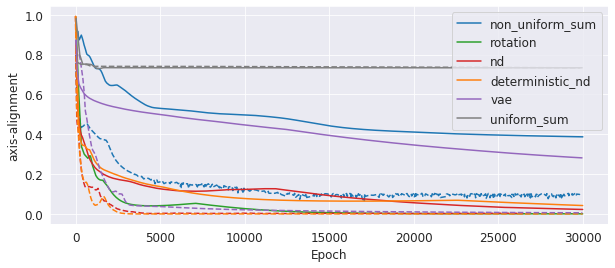

In [12]:
generate_fig2('axis-alignment', show_legend=True, yscale='linear')

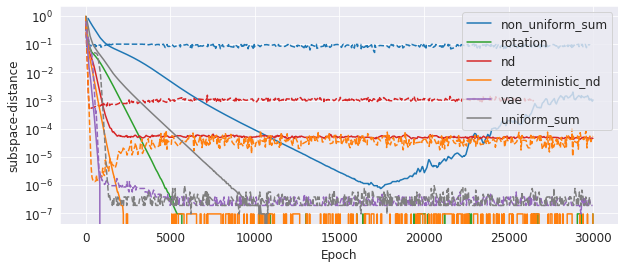

In [13]:
generate_fig2('subspace-distance', show_legend=True, yscale='log')

In [14]:

%debug

ERROR:root:No traceback has been produced, nothing to debug.
